# Import

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, average_precision_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix,classification_report


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

from datetime import datetime
import datetime as dt
import time
import sys
import gc
import pickle
sys.version_info

import joblib
import pickle

original data from shopee

In [18]:
login = pd.read_csv('login.csv')
purchase_detail = pd.read_csv('purchase_detail.csv')
user_label_train = pd.read_csv('user_label_train.csv')
submission = pd.read_csv('submission.csv')

user_info is already processed
* transform gender to 1/0
* calculate age by birthday
* calculate enroll days by enroll date
* eliminate extreme and unreasonable value

In [4]:
user_info = pd.read_csv('user_info_processed.csv')

# Data process

## base

setting data type
* training:1
* testing:2

In [88]:
user_label_train['data_type'] = 1

submission['data_type'] = 2
submission['label'] = 0

merge base data with user info

In [89]:
df = pd.concat([user_label_train, submission], axis=0)
df = pd.merge(df, user_info, how='left', on='userid')

## purchase detail

### count and amount

In [91]:
purchase_detail['date'] = purchase_detail['grass_date'].apply( lambda x: np.datetime64(x))
purchase_detail['month'] = purchase_detail['date'].dt.month

In [92]:
purchase = purchase_detail.groupby(['userid','month']).agg(avg_count=('order_count', 'mean'),
                                                           total_count=('order_count', 'sum'),
                                                           avg_amount=('total_amount', 'mean'),
                                                           total_amount=('total_amount', 'sum')).reset_index()

In [93]:
avg_amount = purchase.pivot(index='userid', columns='month', values='avg_amount').reset_index()
avg_amount.columns = ['userid', 'avg_amount_2','avg_amount_3','avg_amount_4','avg_amount_5','avg_amount_6','avg_amount_7']
avg_amount = avg_amount.fillna(0)

total_amount = purchase.pivot(index='userid', columns='month', values='total_amount').reset_index()
total_amount.columns = ['userid', 'total_amount_2','total_amount_3','total_amount_4','total_amount_5','total_amount_6','total_amount_7']
total_amount = total_amount.fillna(0)

avg_count = purchase.pivot(index='userid', columns='month', values='avg_count').reset_index()
avg_count.columns = ['userid', 'avg_count_2','avg_count_3','avg_count_4','avg_count_5','avg_count_6','avg_count_7']
avg_count = avg_count.fillna(0)

total_count = purchase.pivot(index='userid', columns='month', values='total_count').reset_index()
total_count.columns = ['userid', 'total_count_2','total_count_3','total_count_4','total_count_5','total_count_6','total_count_7']
total_count = total_count.fillna(0)

In [94]:
df = pd.merge(df, avg_amount, how='left', on='userid')
df = pd.merge(df, total_amount, how='left', on='userid')
df = pd.merge(df, avg_count, how='left', on='userid')
df = pd.merge(df, total_count, how='left', on='userid')

### category

In [96]:
cat = purchase_detail.groupby(['userid','category_encoded'], as_index=False).size().reset_index()
cat.columns = ['userid', 'category_encoded', 'size']
cat = cat.pivot(index='userid', columns='category_encoded', values='size').reset_index()
cat = cat.fillna(0)

In [97]:
df = pd.merge(df, cat, how='left', on='userid')

### purchase variation

In [98]:
df['total_amount_56']=df['total_amount_6']/(df['total_amount_5']+0.00000000001)
df['total_amount_67']=df['total_amount_7']/(df['total_amount_6']+0.00000000001)
df['total_amount_45']=df['total_amount_5']/(df['total_amount_4']+0.00000000001)
df['total_amount_27']=df['total_amount_7']/(df['total_amount_2']+0.00000000001)

In [99]:
df['avg_amount_56']=df['avg_amount_6']/(df['avg_amount_5']+0.00000000001)
df['avg_amount_67']=df['avg_amount_7']/(df['avg_amount_6']+0.00000000001)
df['avg_amount_45']=df['avg_amount_5']/(df['avg_amount_4']+0.00000000001)
df['avg_amount_27']=df['avg_amount_7']/(df['avg_amount_2']+0.00000000001)

In [100]:
df.head()

,userid,label,data_type,gender,is_seller,age,enroll_how_long,avg_amount_2,avg_amount_3,avg_amount_4,avg_amount_5,avg_amount_6,avg_amount_7,total_amount_2,total_amount_3,total_amount_4,total_amount_5,total_amount_6,total_amount_7,avg_count_2,avg_count_3,avg_count_4,avg_count_5,avg_count_6,avg_count_7,total_count_2,total_count_3,total_count_4,total_count_5,total_count_6,total_count_7,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,total_amount_56,total_amount_67,total_amount_45,total_amount_27,avg_amount_56,avg_amount_67,avg_amount_45,avg_amount_27
0,243381,0,1,1.0,0,20.0,1251,1.000000,250.000000,3.000000,0.000000,1.000000,0.000000,1.0,250.0,3.0,0.0,1.0,0.0,1.000000,1.00,2.000000,0.000000,1.000000,0.000000,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000e+11,0.000000,0.000000,0.000000,1.000000e+11,0.000000,0.000000,0.000000
1,150139,1,1,1.0,1,NaN,1463,1.000000,0.000000,0.000000,0.000000,2.333333,2.000000,3.0,0.0,0.0,0.0,7.0,6.0,1.000000,0.00,0.000000,0.000000,2.333333,2.000000,3.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000e+11,0.857143,0.000000,2.000000,2.333333e+11,0.857143,0.000000,2.000000
2,305902,1,1,1.0,0,33.0,1095,5.000000,1.500000,1.500000,2.000000,2.000000,3.000000,5.0,3.0,3.0,2.0,2.0,6.0,5.000000,1.00,1.500000,2.000000,2.000000,3.000000,5.0,2.0,3.0,2.0,2.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,3.000000,0.666667,1.200000,1.000000e+00,1.500000,1.333333,0.600000
3,159981,0,1,0.0,1,35.0,1441,5.416667,17.666667,5.000000,3.500000,6.250000,1.857143,65.0,53.0,15.0,21.0,25.0,13.0,2.583333,2.00,1.333333,1.833333,5.750000,1.285714,31.0,6.0,4.0,11.0,23.0,9.0,0.0,0.0,1.0,0.0,1.0,13.0,0.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.190476e+00,0.520000,1.400000,0.200000,1.785714e+00,0.297143,0.700000,0.342857
4,490632,0,1,1.0,1,NaN,375,2.900000,2.000000,2.333333,2.111111,1.250000,2.333333,29.0,16.0,14.0,19.0,5.0,7.0,1.600000,1.25,1.166667,1.333333,1.250000,2.000000,16.0,10.0,7.0,12.0,5.0,6.0,0.0,2.0,0.0,0.0,7.0,2.0,0.0,13.0,0.0,5.0,0.0,0.0,1.0,6.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.631579e-01,1.400000,1.357143,0.241379,5.921053e-01,1.866667,0.904762,0.804598


## login

### average and total

In [101]:
login['date'] = pd.to_datetime(login['date'])
login['login_mm'] = login['date'].dt.month

In [102]:
login_avg = login.groupby(['userid','login_mm'], as_index=False).agg({'login_times': 'mean'})

login_avg = login_avg.pivot(index='userid', columns='login_mm', values=['login_times']).reset_index()
login_avg.columns = ['userid', 'avg_login_2','avg_login_3','avg_login_4','avg_login_5','avg_login_6','avg_login_7']

In [103]:
login_sum =login.groupby(['userid','login_mm'], as_index=False).agg({'login_times': 'sum'})

login_sum = login_sum.pivot(index='userid', columns='login_mm', values=['login_times']).reset_index()
login_sum.columns = ['userid', 'tot_login_2','tot_login_3','tot_login_4','tot_login_5','tot_login_6','tot_login_7']

In [104]:
df = pd.merge(df, login_avg, how='left', on='userid')
df = pd.merge(df, login_sum, how='left', on='userid')

### login variation

In [105]:
df['rate_login_56']=df['avg_login_6']/(df['avg_login_5']+0.00000000001)
df['rate_login_67']=df['avg_login_7']/(df['avg_login_6']+0.00000000001)
df['rate_login_45']=df['avg_login_5']/(df['avg_login_4']+0.00000000001)
df['rate_login_27']=df['avg_login_7']/(df['avg_login_2']+0.00000000001)

## Final data set

In [108]:
df_all = df.copy()

# Modeling

## training

In [110]:
exclude_col = [
    'userid',
    'data_type']

y_col = ['label']

x_col = list(set(df_all.columns.tolist())-set(exclude_col)-set(y_col))

In [112]:
x_train = df_all[df_all['data_type']==1][x_col]
y_train = df_all[df_all['data_type']==1][y_col]

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 1)

In [113]:
train_dm = xgb.DMatrix(data=x_train, label=y_train)
valid_dm = xgb.DMatrix(data=x_valid, label=y_valid)

In [114]:
params ={ 'booster':'gbtree',
              
          'binary':'logistic',   
          'eval_metric': 'auc',
         
          'max_depth': 7,
          'min_child_weight':100, 
          'gamma':0, 
          'scale_pos_weight':7,
           
          'subsample':0.8,
          'colsample_bytree':0.8,
          'eta':0.1,  
         
          'random_state':7,
          'silent':0 
        }


evallist = [(train_dm,'train'), (valid_dm,'eval')]
evals_result = {}

In [ ]:
model = xgb.train(params, train_dm, num_boost_round=1000, evals=evallist, early_stopping_rounds=30, evals_result=evals_result)

### feature importance

* find the important features and create new features  

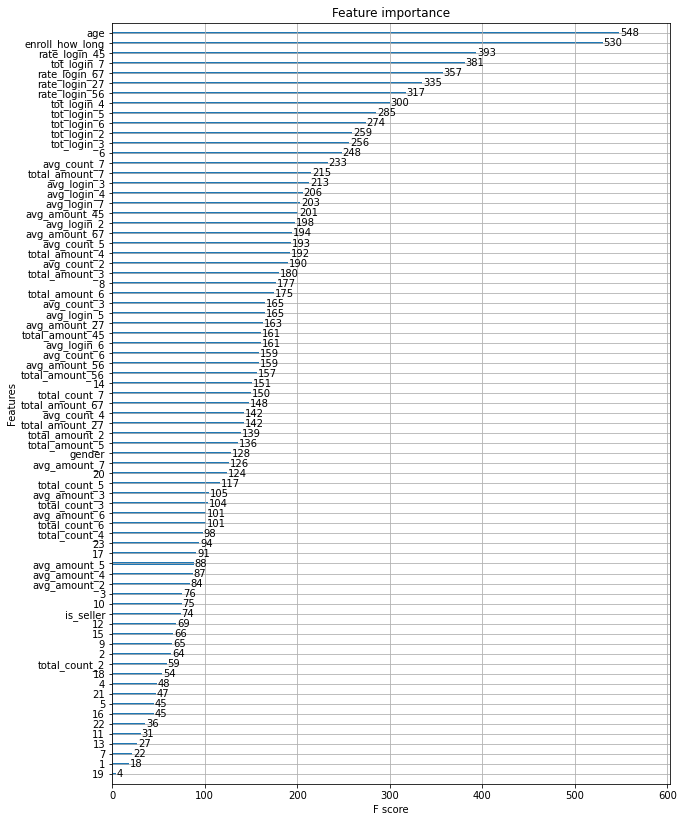

In [116]:
plot_features(model, (10,14))

## final model

In [117]:
params ={ 'booster':'gbtree',
              
          'binary':'logistic',   
          'eval_metric': 'auc',
         
          'max_depth': 7,
          'min_child_weight':100, 
          'gamma':0, 
          'scale_pos_weight':7,
           
          'subsample':0.8,
          'colsample_bytree':0.8,
          'eta':0.1,  
         
          'random_state':7,
          'silent':0 
        }


In [118]:
x_all = df_all[df_all['data_type']==1][x_col]
y_all = df_all[df_all['data_type']==1][y_col]
all_dm = xgb.DMatrix(data=x_all, label=y_all)

In [119]:
# num_boost_round is setting the best iteration
model = xgb.train(params, all_dm, num_boost_round=300)

[11:44:36] WARNING: /private/var/folders/bc/wfl4zykj6d12k36jq7qfh8g00000gn/T/pip-install-sblw_y2e/xgboost/xgboost/src/learner.cc:328: 
Parameters: { binary, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## prediction

In [144]:
x_test = df_all[df_all['data_type']==2][x_col]
test_dm = xgb.DMatrix(data = x_test)

y_pred = model.predict(test_dm)

array([ 0.67801774,  0.91292274,  0.9460194 , ...,  0.98105407,
        0.5888169 , -0.01573628], dtype=float32)